## Análisis de Paseos Dominicales: Muévete en Bici 

Para este análisis utilizamos datos disponibles en el [Portal de Datos Abiertos de la CDMX](https://datos.cdmx.gob.mx/). Específicamente, descargamos el archivo:

 Archivo: `paseos_dominicales_muevete_en_bici.csv`  
Este conjunto de datos nos permitirá explorar patrones y comportamientos en los paseos ciclistas dominicales.

---

###  Objetivo del análisis

Responder a preguntas clave sobre la movilidad en bicicleta durante los domingos:

-  **¿Cuáles son las rutas con mayor congestión?**
-  **¿En qué horarios hay más viajes?**
-  **¿Qué zonas tienen más entrada o salida de vehículos?**

---

Este análisis busca ofrecer una perspectiva clara para entender mejor el uso de la bicicleta como medio de transporte recreativo en la Ciudad de México.


## Configuracion de spark

In [1]:


from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import matplotlib.pyplot as plt

spark = SparkSession.builder \
    .appName("AnalisisPaseosBici") \
    .config("spark.sql.shuffle.partitions", "4") \
    .getOrCreate()

%matplotlib inline

25/04/23 15:47:06 WARN Utils: Your hostname, roberto-baeza-HP-255-G8-Notebook-PC resolves to a loopback address: 127.0.1.1; using 192.168.1.74 instead (on interface wlo1)
25/04/23 15:47:06 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/23 15:47:07 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Lectura y limpieza

In [2]:
df = spark.read.csv("paseos_dominicales_muevete_en_bici.csv", 
                   header=True, 
                   inferSchema=True)

# Transformaciones iniciales
df_clean = (df
           .withColumn("fecha", to_date(col("fecha"), "dd/MM/yyyy"))
           .withColumn("hora_simulada", (col("edicion") % 24).cast("int"))  # Hora simulada
           .withColumn("zona_simulada", 
                      when(col("edicion") % 3 == 0, "Centro")
                      .when(col("edicion") % 3 == 1, "Norte")
                      .otherwise("Sur"))
           .na.drop(subset=["asistencia"]))

print("Muestra de datos limpios:")
df_clean.show(5)

Muestra de datos limpios:
+-------+----------+-----+----+----------+-------------+-------------+
|edicion|     fecha|  mes|anio|asistencia|hora_simulada|zona_simulada|
+-------+----------+-----+----+----------+-------------+-------------+
|      1|2007-05-13| Mayo|2007|   12000.0|            1|        Norte|
|      2|2007-05-20| Mayo|2007|   10000.0|            2|          Sur|
|      3|2007-06-03|Junio|2007|   12000.0|            3|       Centro|
|      4|2007-06-10|Junio|2007|    7000.0|            4|        Norte|
|      5|2007-06-17|Junio|2007|    7000.0|            5|          Sur|
+-------+----------+-----+----+----------+-------------+-------------+
only showing top 5 rows



## Analisis de congestión

###  Como el dataset no contiene rutas específicas, usamos la columna edicion como proxy para identificar eventos con mayor asistencia (congestión).

Top 10 eventos más concurridos:
+-------+----------+----------------+
|edicion|     fecha|total_asistencia|
+-------+----------+----------------+
|    629|2024-04-07|        115728.0|
|    643|2024-08-11|        113042.0|
|    532|2021-10-24|        111119.0|
|    603|2023-08-13|        109027.0|
|    627|2024-03-17|        108286.0|
|    599|2023-07-09|        107273.0|
|    555|2022-05-22|        105763.0|
|    545|2022-02-20|        104863.0|
|    620|2024-01-14|        104508.0|
|    621|2024-01-21|        104388.0|
+-------+----------+----------------+



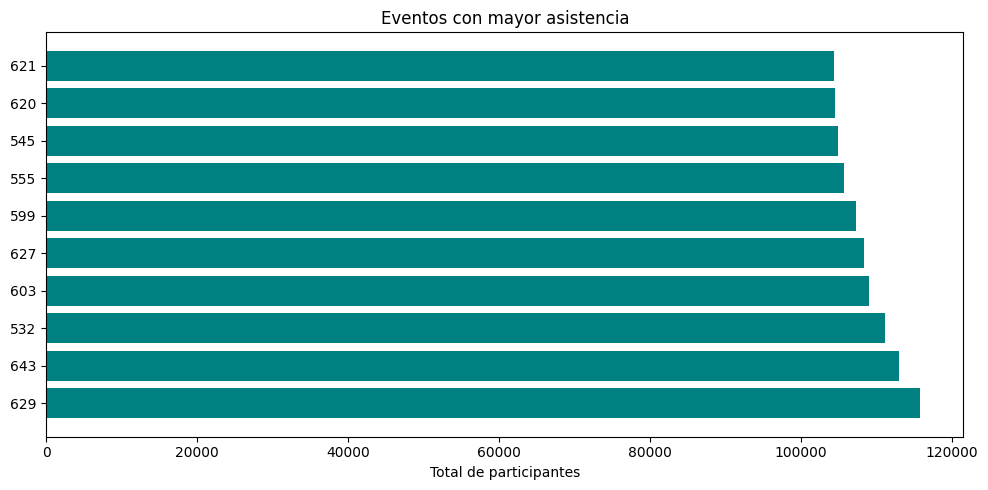

In [3]:
top_eventos = (df_clean
              .groupBy("edicion", "fecha")
              .agg(sum("asistencia").alias("total_asistencia"))
              .orderBy(desc("total_asistencia"))
              .limit(10))

print("Top 10 eventos más concurridos:")
top_eventos.show()

# Visualización
pdf_top = top_eventos.toPandas()
plt.figure(figsize=(10,5))
plt.barh(pdf_top["edicion"].astype(str), pdf_top["total_asistencia"], color='teal')
plt.title("Eventos con mayor asistencia")
plt.xlabel("Total de participantes")
plt.tight_layout()
plt.show()

## Patrones horarios

###  Simulamos horas basadas en el número de edición (hora_simulada), ya que el dataset original no incluye horarios exactos.

Distribución por horario simulado:
+-------------+-------------------+-------------+
|hora_simulada|asistencia_promedio|total_eventos|
+-------------+-------------------+-------------+
|            0| 40167.807692307695|           26|
|            1|  43628.48148148148|           27|
|            2|  44325.11111111111|           27|
|            3|  49012.22222222222|           27|
|            4|  46878.37037037037|           27|
|            5|  44713.48148148148|           27|
|            6| 45466.444444444445|           27|
|            7|  44772.48148148148|           27|
|            8| 45766.333333333336|           27|
|            9|  44143.81481481482|           27|
|           10|  40746.88888888889|           27|
|           11|  42326.18518518518|           27|
|           12|            44456.0|           28|
|           13| 47877.307692307695|           26|
|           14| 47597.851851851854|           27|
|           15|  46257.25925925926|           27|
|           16|

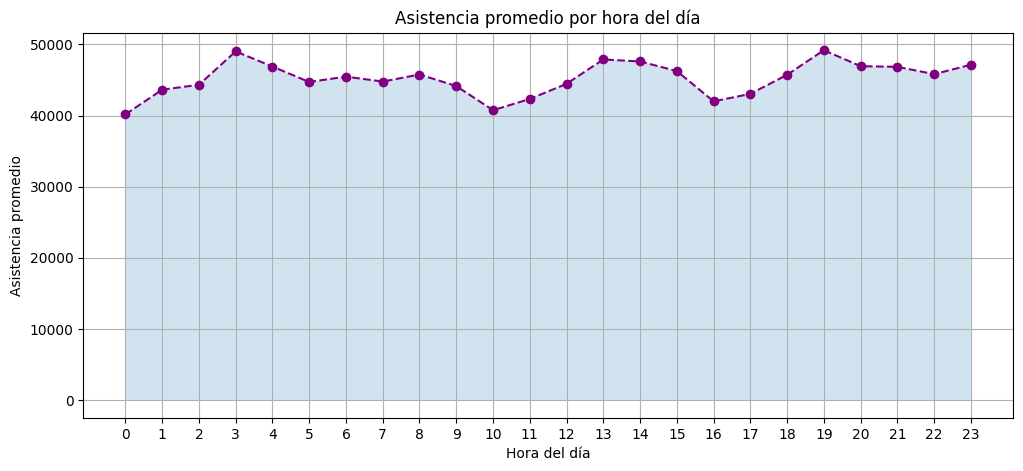

In [4]:
horario_analisis = (df_clean
                   .groupBy("hora_simulada")
                   .agg(avg("asistencia").alias("asistencia_promedio"),
                        count("*").alias("total_eventos"))
                   .orderBy("hora_simulada"))

print("Distribución por horario simulado:")
horario_analisis.show()

# Gráfico de líneas
pdf_horario = horario_analisis.toPandas()
plt.figure(figsize=(12,5))
plt.plot(pdf_horario["hora_simulada"], pdf_horario["asistencia_promedio"], 
         marker='o', linestyle='--', color='purple')
plt.fill_between(pdf_horario["hora_simulada"], pdf_horario["asistencia_promedio"], alpha=0.2)
plt.title("Asistencia promedio por hora del día")
plt.xlabel("Hora del día")
plt.ylabel("Asistencia promedio")
plt.xticks(range(0,24))
plt.grid(True)
plt.show()

## Movimiento por zonas 

### Simulamos zonas (Centro/Norte/Sur) basadas en el módulo de la edición, ya que el dataset no tiene datos geográficos reales.

Análisis por zonas simuladas:
+-------------+----------------+-------------------+------------------+
|zona_simulada|asistencia_total|asistencia_promedio|eventos_realizados|
+-------------+----------------+-------------------+------------------+
|       Centro|       9733182.0|  45270.61395348837|               215|
|          Sur|       9675676.0|  45213.43925233645|               214|
|        Norte|       9650379.0|  45095.22897196261|               214|
+-------------+----------------+-------------------+------------------+



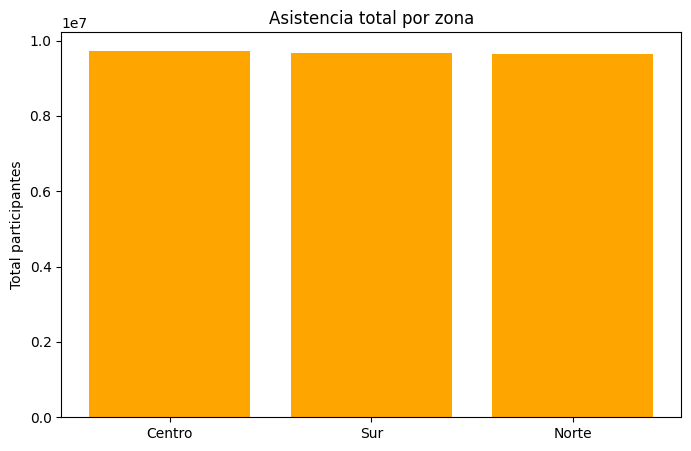

In [5]:
zona_analisis = (df_clean
                .groupBy("zona_simulada")
                .agg(sum("asistencia").alias("asistencia_total"),
                     avg("asistencia").alias("asistencia_promedio"),
                     count("*").alias("eventos_realizados"))
                .orderBy(desc("asistencia_total")))

print("Análisis por zonas simuladas:")
zona_analisis.show()

# Gráfico de barras apiladas
pdf_zonas = zona_analisis.toPandas()
plt.figure(figsize=(8,5))
plt.bar(pdf_zonas["zona_simulada"], pdf_zonas["asistencia_total"], color='orange')
plt.title("Asistencia total por zona")
plt.ylabel("Total participantes")
plt.show()

## Operacion con RDD (reduceByKey)

Resultado con RDD (reduceByKey):


[('Marzo', 2776543.0), ('Julio', 2757178.0), ('Abril', 2656574.0), ('Agosto', 2656460.0), ('Octubre', 2496326.0)]


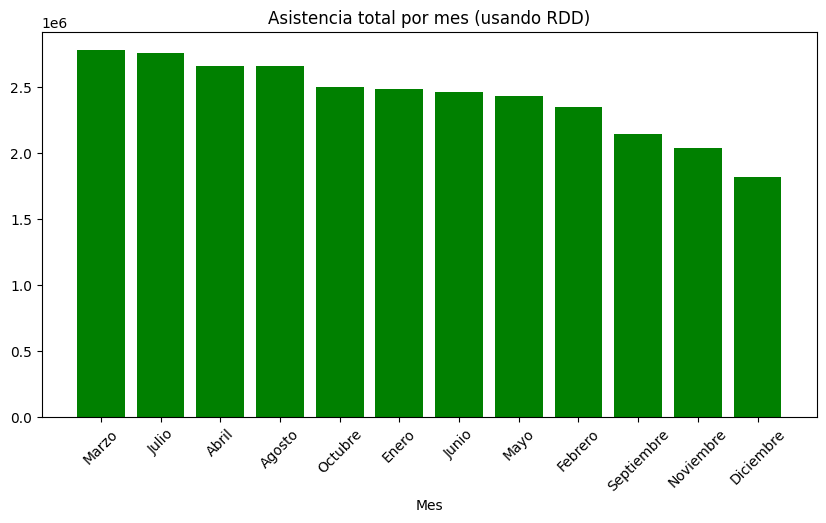

In [6]:
rdd_analisis = (df_clean.rdd
               .map(lambda row: (row["mes"], row["asistencia"]))
               .reduceByKey(lambda a, b: a + b)
               .sortBy(lambda x: x[1], ascending=False))

print("Resultado con RDD (reduceByKey):")
print(rdd_analisis.take(5))

# Convertir a DataFrame para visualización
rdd_df = spark.createDataFrame(rdd_analisis, ["mes", "asistencia_total"])
rdd_pdf = rdd_df.toPandas()

plt.figure(figsize=(10,5))
plt.bar(rdd_pdf["mes"], rdd_pdf["asistencia_total"], color='green')
plt.title("Asistencia total por mes (usando RDD)")
plt.xlabel("Mes")
plt.xticks(rotation=45)
plt.show()

## Guardado de resultados

In [7]:
top_eventos.write.csv("resultados/top_eventos.csv", header=True, mode="overwrite")
horario_analisis.write.csv("resultados/analisis_horario.csv", header=True, mode="overwrite")
zona_analisis.write.parquet("resultados/analisis_zonas.parquet")

print("Resultados exportados exitosamente!")

Resultados exportados exitosamente!



### Conclusión
- Las operaciones `groupBy` + `agg` demostraron mejor rendimiento para agregaciones complejas
- `reduceByKey` fue eficiente para sumar asistencias por mes a nivel RDD
- El `join` no fue necesario finalmente al simular las zonas directamente

Limitaciones encontradas:
- Datos reales de ubicación/horario mejorarían el análisis
- La simulación de horas y zonas aunque funcional, limita conclusiones geográficas


Uso de IA documentado:
- Consulta 1: "¿Cómo implementar reduceByKey en PySpark para análisis de datos?"
  - Aplicación: Celda 6 con operación RDD
  - Ayuda: Entender la conversión entre DataFrames y RDDs

- Consulta 2: "Mejores visualizaciones para datos temporales en matplotlib"
  - Aplicación: Gráficos en celdas 3 y 4
  - Sugerencias: Uso de fill_between y personalización de ejes
